#
#   Stochastic Processes - class 1/2024 - University of Brasília
#   Computational work 1 - Requantization and image analysis
#
#   Gabriel Tambara Rabelo - 241106461
#
#   References:
#   https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
#   https://docs.opencv.org/4.9.0/d4/d1b/tutorial_histogram_equalization.html
#   https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html
#

In [59]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from math import sqrt

img_size = 300
images_addr = ["folha.jpg", "torso.png", "coisa.jpg", "cerebro.jpg", "cerebro-tumor.jpg"]
images = []

# control of when to stop showing images and progressing in the processing
def waitKey():
    cv.waitKey(0)
    cv.destroyAllWindows()

# show images
def printAll(list, subtitle):
    for i in range(len(list)):
        cv.imshow(images_addr[i] + subtitle, list[i])

# save images in the correct folder
def saveAll(list, subtitle):
    for i in range(len(list)):
        cv.imwrite("./images/" + images_addr[i][0:-4] + subtitle + images_addr[i][-4:], list[i])

# generate a histogram based on the data from list and size from sizereference and evaluate with b_numbers if additional peaks data are shown
def generateHist(sizereference, list, name, b_numbers):
    hist = []
    for i in range(len(sizereference)):
        hist.append(cv.calcHist([list[i]], [0], None, [256], [0, 256]).flatten())
        plt.figure()
        plt.title("Histogram of " + images_addr[i])
        plt.xlabel("Pixel values")
        plt.ylabel("Ocurrences (px)")
        plt.step(range(256), hist[i], where='mid', label='mid')

        if b_numbers is True:
            peaks, _ = find_peaks(hist[i], 1)
            bbox = dict(boxstyle="round", fc="0.8")
            for peak in peaks:
                annotation_str = "[{}, {}]".format(int(hist[i][peak]), peak)
                plt.annotate(annotation_str, xy=(peak, hist[i][peak]), xytext=(peak, hist[i][peak] + 100),
                            arrowprops=dict(arrowstyle='fancy'), horizontalalignment='center', bbox=bbox)

        #plt.show()
        plt.savefig("./images/hist_" + images_addr[i][0:-4] + name + images_addr[i][-4:])

        plt.figure()
        plt.title("Normalized histogram of " + images_addr[i])
        plt.xlabel("Pixel values")
        plt.ylabel("Area (px²)")

        normalized_hist = [sqrt(x) for x in hist[i]]

        plt.step(range(256), normalized_hist, where='mid', label='mid', color='orange')

        if b_numbers is True:
            peaks, _ = find_peaks(normalized_hist, 1)
            bbox = dict(boxstyle="round", fc="0.8")
            for peak in peaks:
                annotation_str = "[{}, {}]".format(int(normalized_hist[peak]), peak)
                plt.annotate(annotation_str, xy=(peak, normalized_hist[peak]), xytext=(peak, normalized_hist[peak] + 1),
                            arrowprops=dict(arrowstyle='fancy'), horizontalalignment='center', bbox=bbox)

        #plt.show()
        plt.savefig("./images/hist_normalized_" + images_addr[i][0:-4] + name + images_addr[i][-4:])

# gerenate bits colored resolution image data from input with kmeans
def kmeans(input, bits):
    images_formatted = []
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    for i in range(len(input)):
        images_formatted.append(np.float32(input[i]).reshape(-1, 3))
        compactness, labels, center = cv.kmeans(images_formatted[i], 2**bits, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        final_img = center[labels.flatten()]
        images_formatted[i] = final_img.reshape(input[i].shape)

    return images_formatted

In [60]:
# reading and viewing images in the folder

for img in images_addr:
    images.append((cv.imread("./images/" + img)))
    ratio = img_size / images[-1].shape[1]
    images[-1] = cv.resize(images[-1], (img_size, int(images[-1].shape[0] * ratio)), cv.INTER_AREA)

saveAll(images, '')
waitKey()

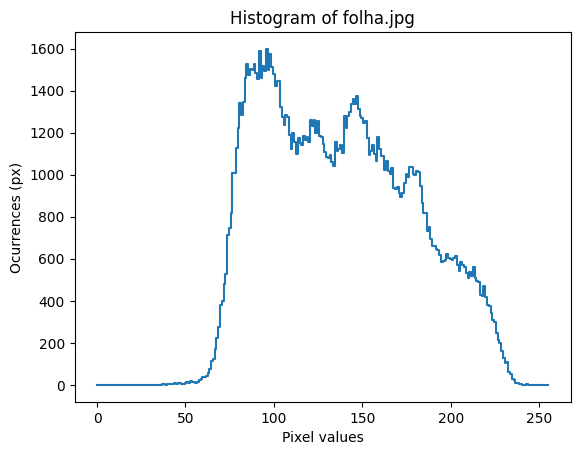

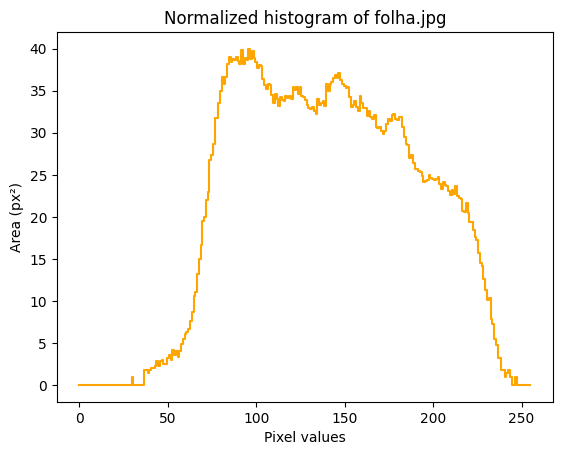

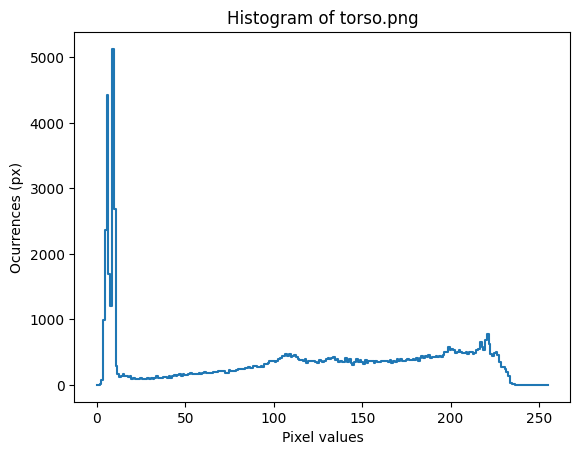

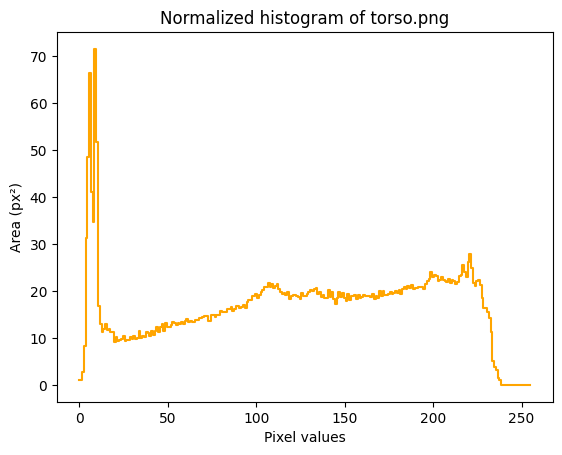

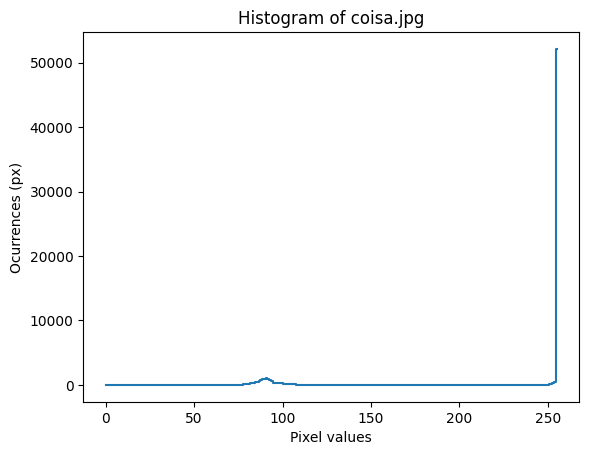

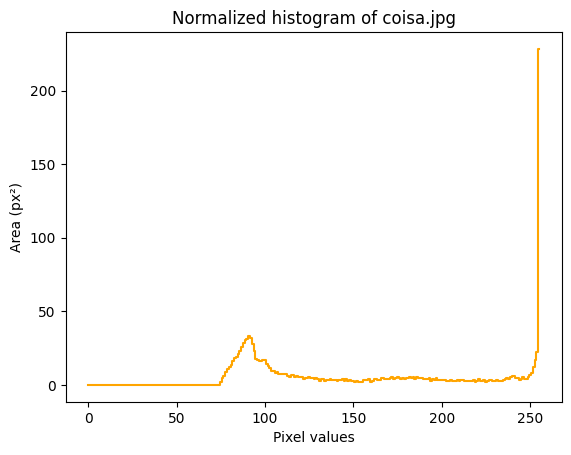

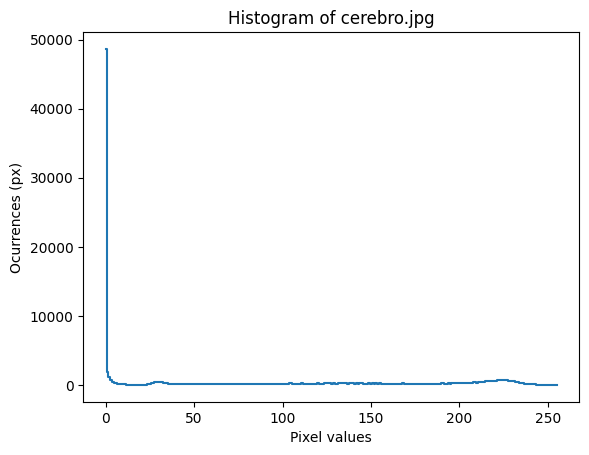

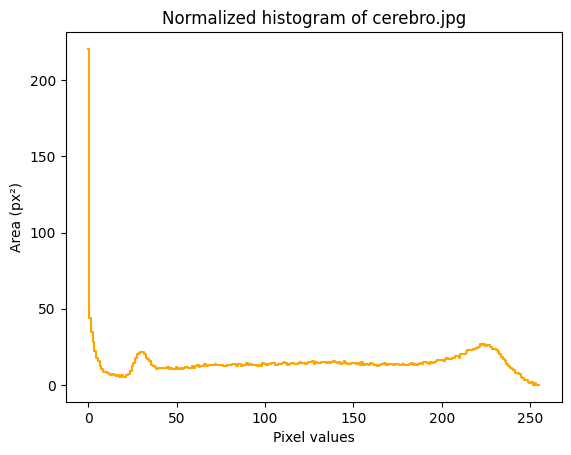

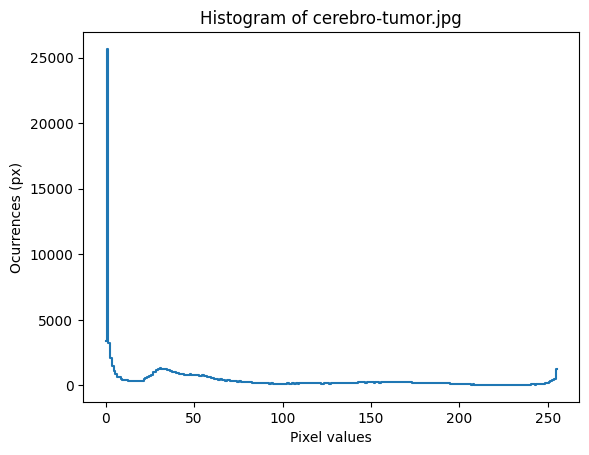

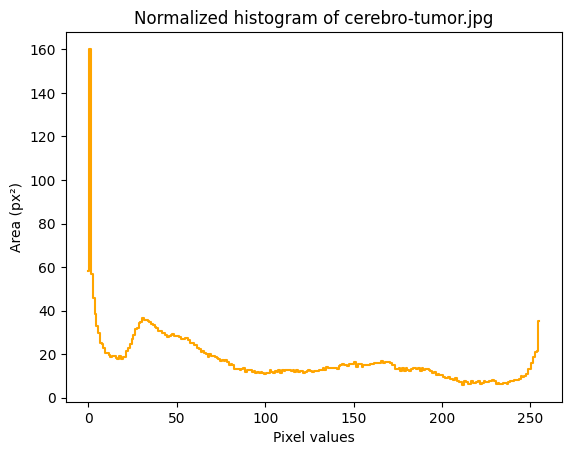

In [61]:
# converting images to gray-scale format

images_bw = []
for i in range(len(images)):
    images_bw.append(cv.cvtColor(images[i], cv.COLOR_BGR2GRAY))

saveAll(images_bw, '')
generateHist(images_bw, images_bw, "_bw_", False)
waitKey()

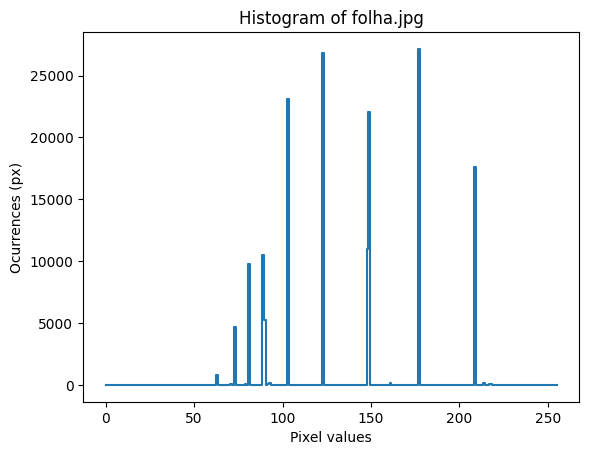

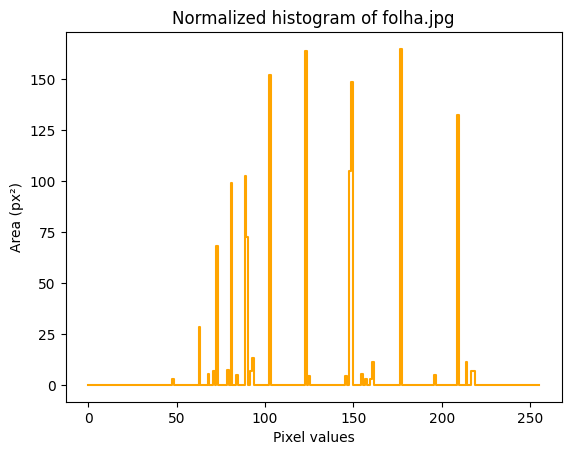

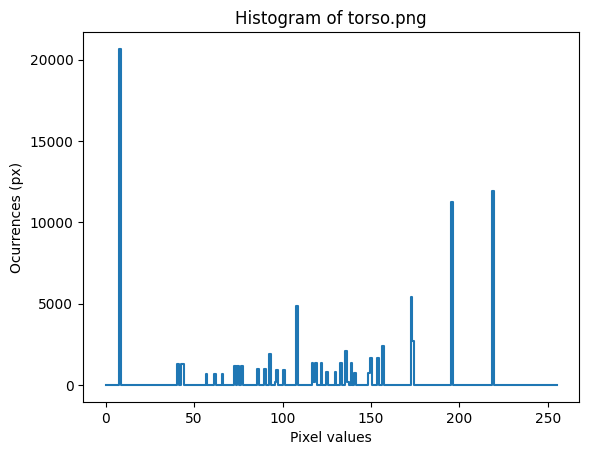

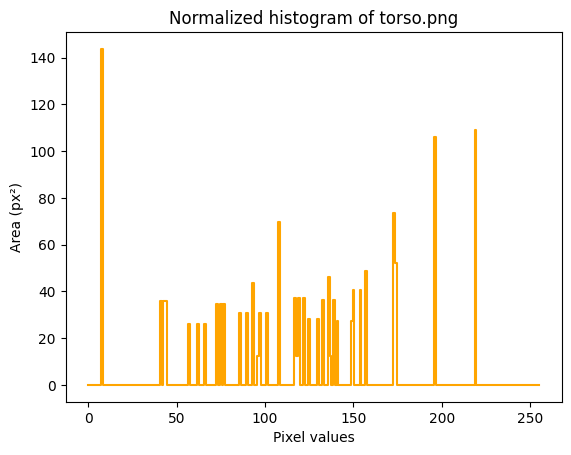

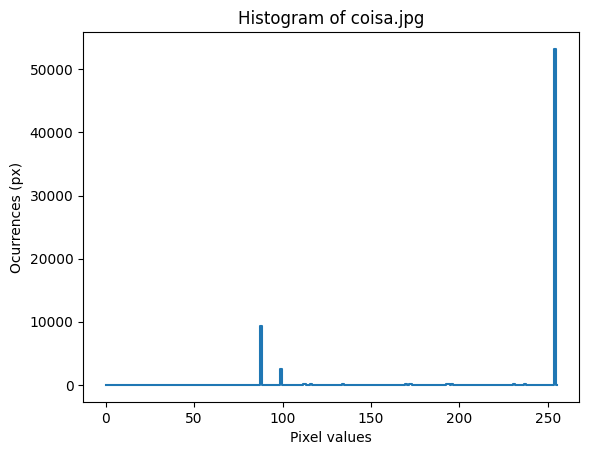

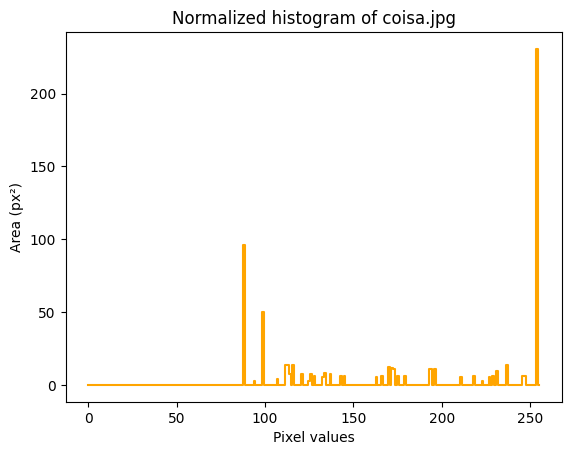

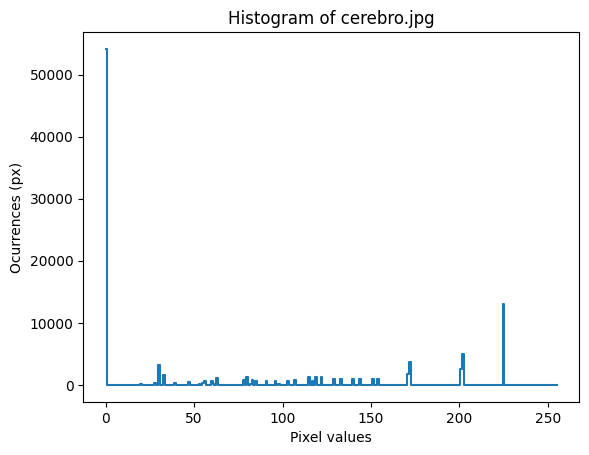

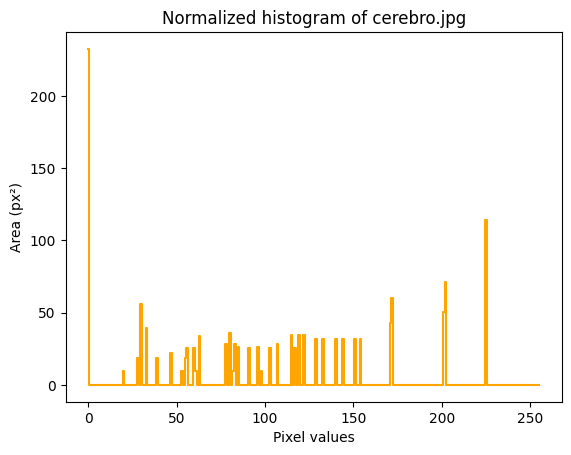

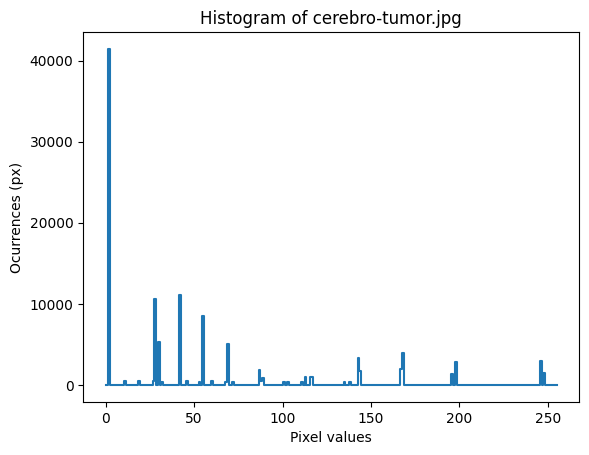

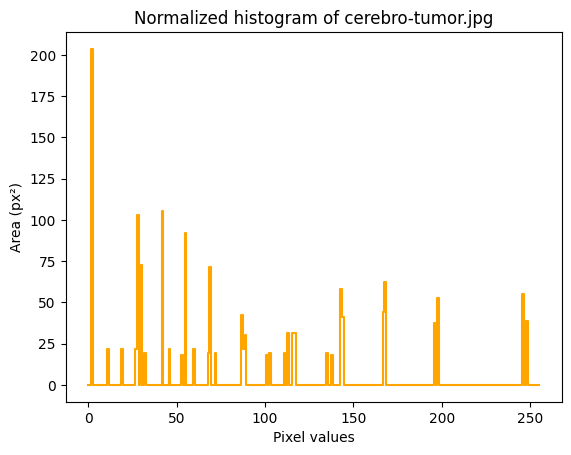

In [62]:
# using quantization with K-MEANS to reduce colors in images to 4 bits of resolution

images_formatted = kmeans(images_bw, 4)
saveAll(images_formatted, " in 4 bits")
generateHist(images_bw, images_formatted, "_kmeans4_", False)
waitKey()

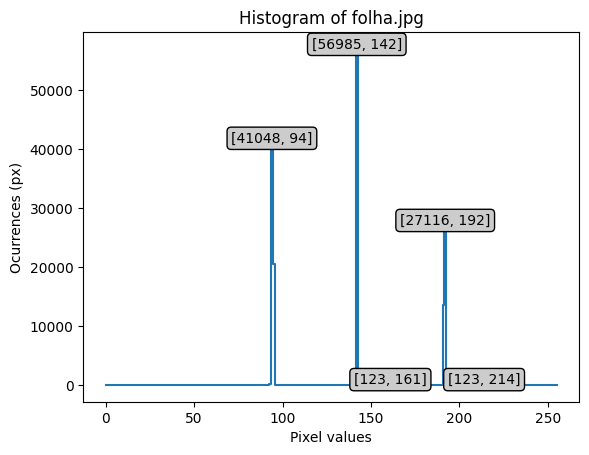

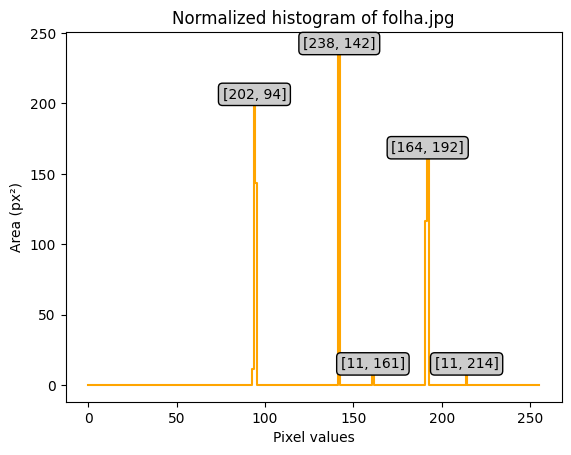

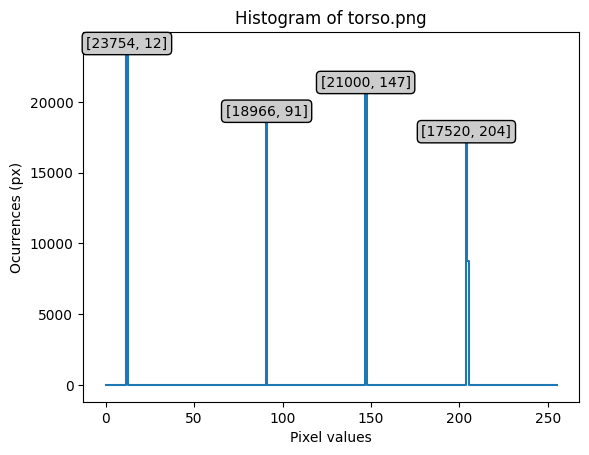

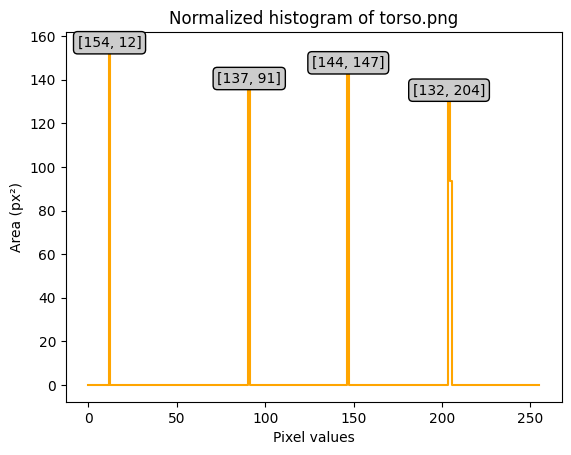

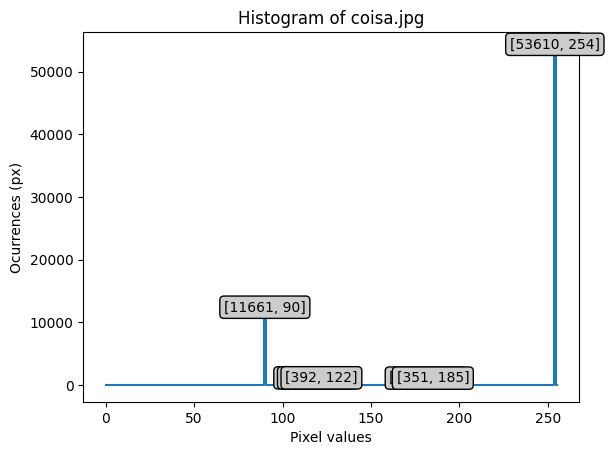

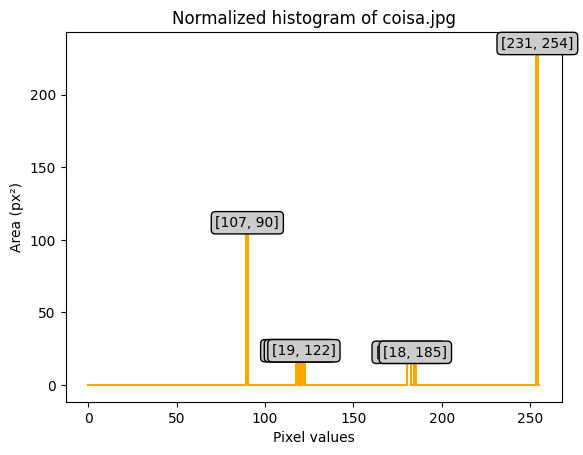

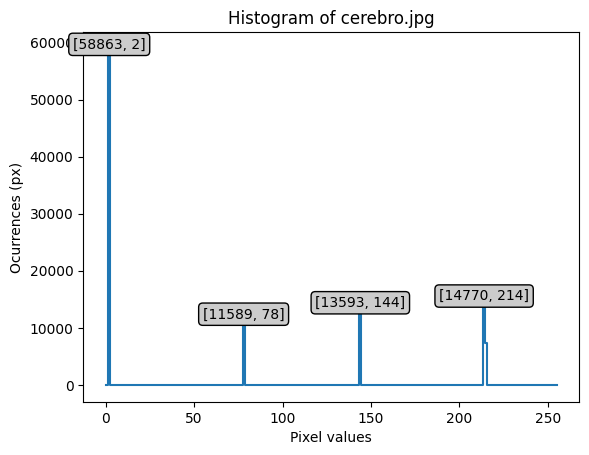

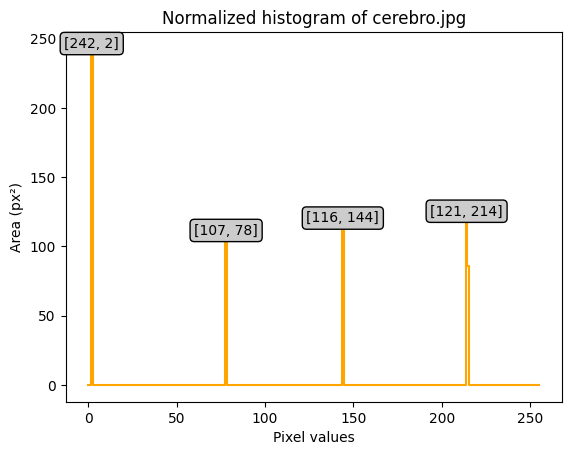

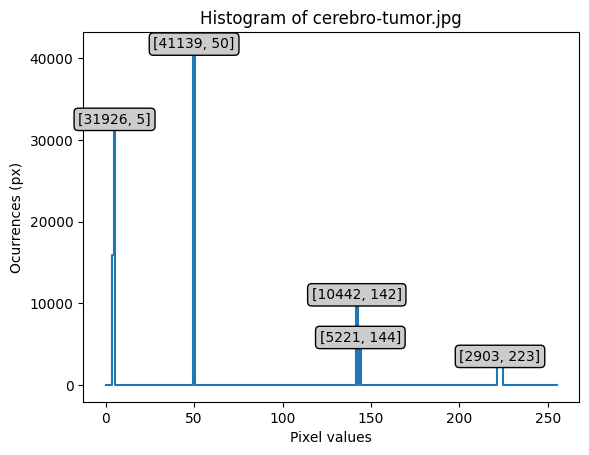

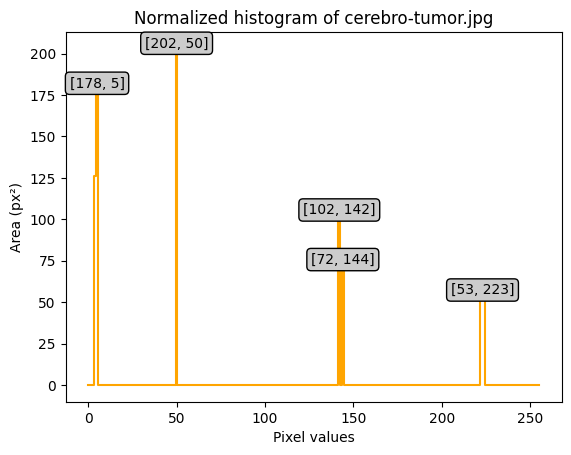

In [63]:
# repeating for 2 bits of resolution

images_formatted = kmeans(images_bw, 2)
saveAll(images_formatted, " in 2 bits")
generateHist(images_bw, images_formatted, "_kmeans2_", True)
waitKey()

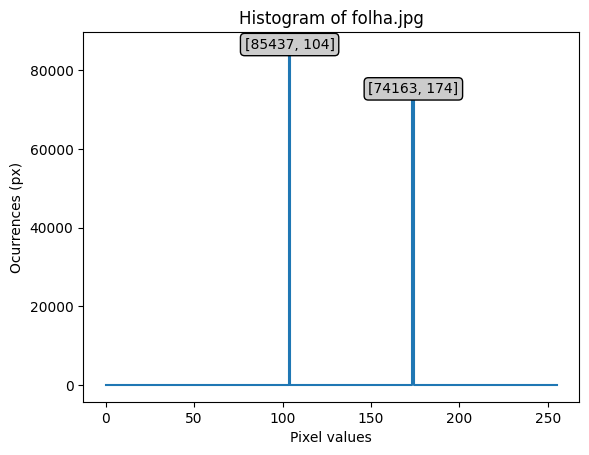

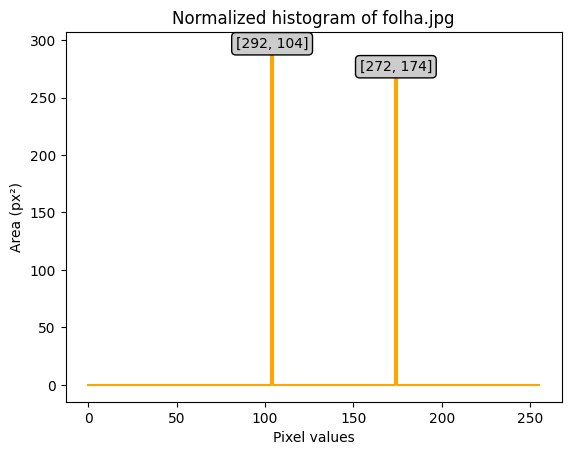

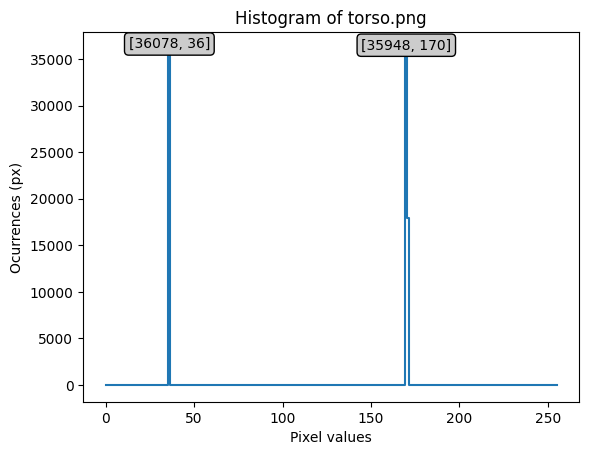

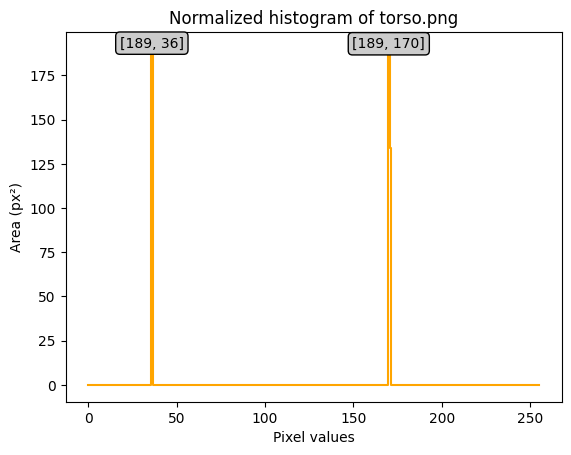

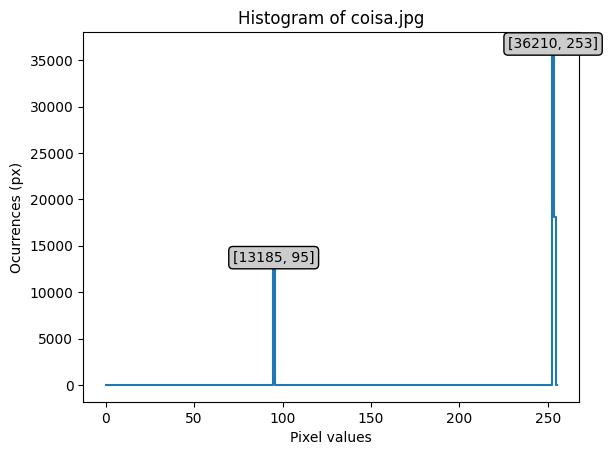

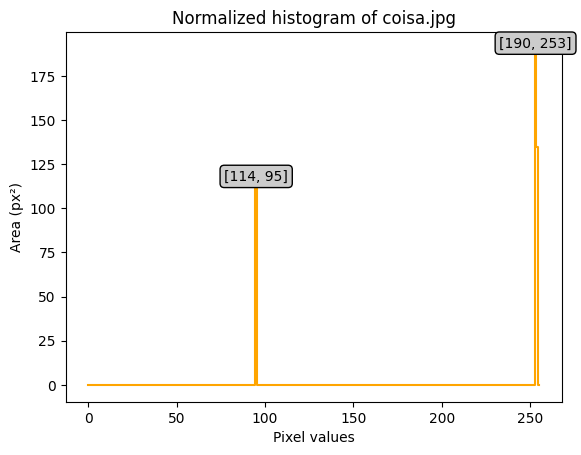

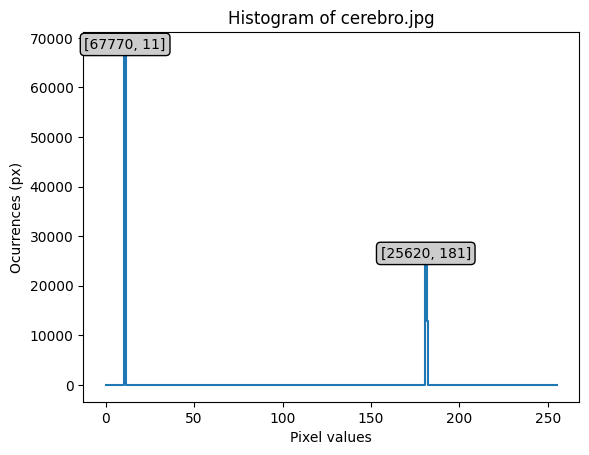

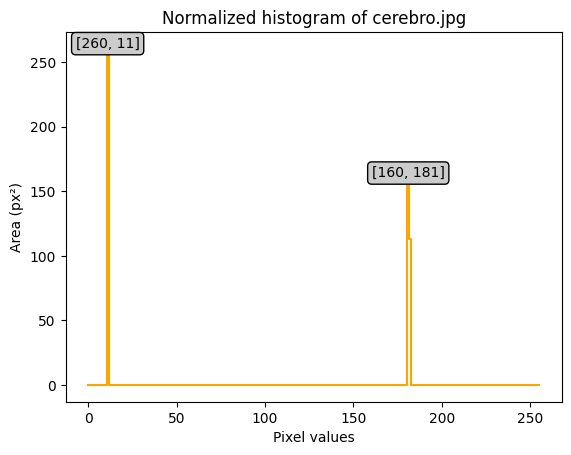

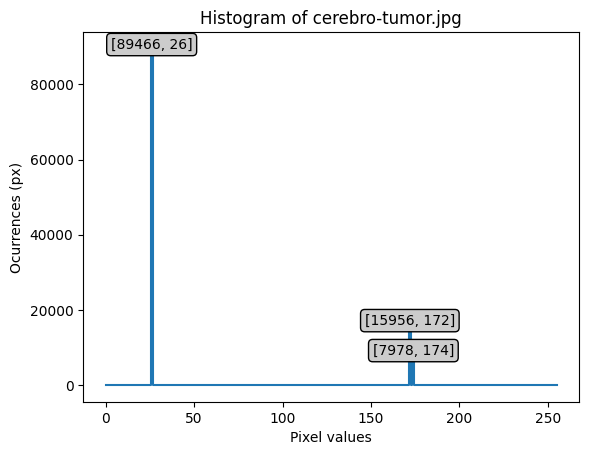

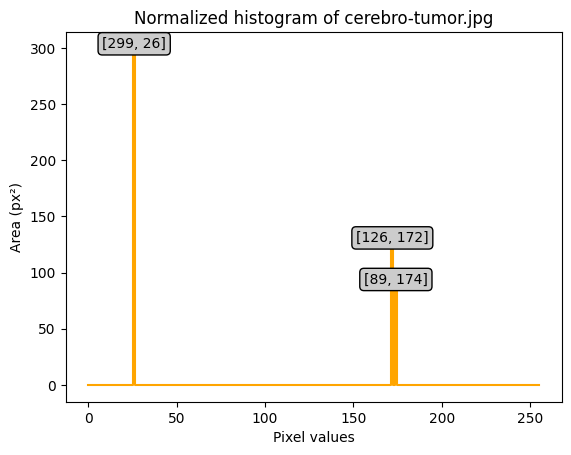

In [64]:
# repeating for 1 bit of resolution

images_formatted = kmeans(images_bw, 1)
saveAll(images_formatted, " in 1 bit")
generateHist(images_bw, images_formatted, "_kmeans1_", True)
waitKey()